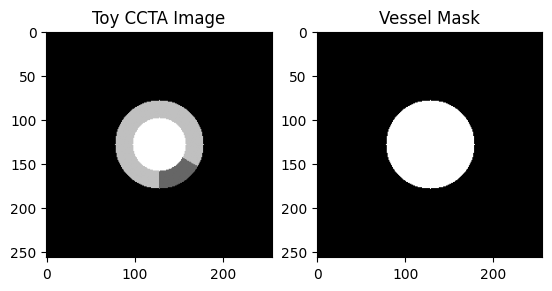

In [2]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def create_toy_ct_image(image_size=256, vessel_center=(128, 128),
                        vessel_radius=50, lumen_radius=30, plaque_angle=(30, 90)):
    # Create a blank image
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    # Draw the vessel wall (simulate intensity ~150)
    cv2.circle(image, vessel_center, vessel_radius, 150, -1)
    # Draw the lumen (simulate intensity ~200)
    cv2.circle(image, vessel_center, lumen_radius, 200, -1)
    # Add a plaque region on one side (simulate intensity ~80)
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.ellipse(mask, vessel_center, (vessel_radius, vessel_radius),
                0, plaque_angle[0], plaque_angle[1], 255, -1)
    image[(mask == 255) & (image == 150)] = 80
    return image

class ToyCTDataset(Dataset):
    def __init__(self, num_images=100):
        self.num_images = num_images
        self.images = [create_toy_ct_image() for _ in range(num_images)]
        # For a segmentation task, we need corresponding masks.
        # Here, we create a simple binary mask for the vessel.
        self.masks = [self.create_vessel_mask(img) for img in self.images]

    def create_vessel_mask(self, image):
        # Simple threshold to segment the vessel wall (value >= 70)
        mask = (image >= 70).astype(np.float32)
        return mask

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        # Normalize image to [0, 1] and add a channel dimension
        image = self.images[idx].astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=0)
        mask = self.masks[idx]
        mask = np.expand_dims(mask, axis=0)
        return torch.tensor(image), torch.tensor(mask)

# Create the dataset and dataloader
dataset = ToyCTDataset(num_images=100)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize one example
img, mask = dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Toy CCTA Image")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Vessel Mask")
plt.show()

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegNet(nn.Module):
    def __init__(self):
        super(SimpleSegNet, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, kernel_size=1)  # Output 1 channel (binary mask)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x_enc = self.pool(x)  # Downsample
        
        # Decoder
        x = F.relu(self.upconv1(x_enc))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

model = SimpleSegNet()
print(model)


SimpleSegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [4]:
import torch.optim as optim

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # For toy experiment; normally many more epochs are required

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

print("Training complete.")


Epoch 1/5, Loss: 0.6992
Epoch 2/5, Loss: 0.3436
Epoch 3/5, Loss: 0.0664
Epoch 4/5, Loss: 0.0110
Epoch 5/5, Loss: 0.0033
Training complete.


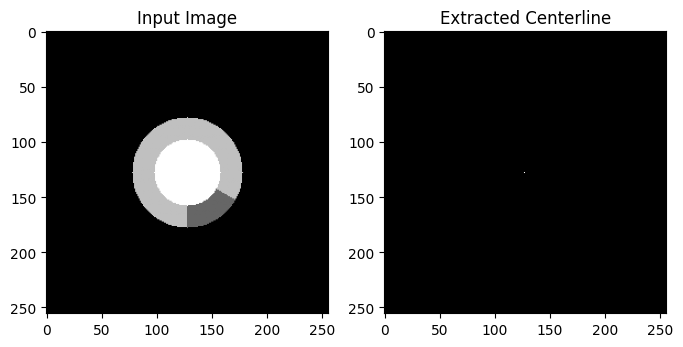

In [7]:
from skimage.morphology import skeletonize

def extract_centerline(mask_tensor):
    # Convert tensor to numpy array
    mask_np = mask_tensor.squeeze().detach().cpu().numpy()
    # Binarize the mask (if necessary)
    binary_mask = mask_np > 0.5
    # Skeletonize the mask
    centerline = skeletonize(binary_mask)
    return centerline

# Example: run the model on one image and extract the centerline
model.eval()
with torch.no_grad():
    sample_img, _ = dataset[0]
    pred_mask = model(sample_img.unsqueeze(0))
    centerline = extract_centerline(pred_mask[0])

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(centerline, cmap='gray')
plt.title("Extracted Centerline")
plt.show()


In [8]:
def compute_diameter(binary_mask):
    # Estimate diameter assuming circular shape: diameter = 2*sqrt(area/pi)
    area = np.sum(binary_mask)
    diameter = 2 * np.sqrt(area / np.pi)
    return diameter

# Simulate lumen segmentation by thresholding (for the toy image, we know lumen intensity is high)
def segment_lumen(image_tensor):
    image_np = image_tensor.squeeze().detach().cpu().numpy()
    lumen_mask = image_np > 0.75  # threshold on normalized intensity (200/255 ~ 0.78)
    return lumen_mask.astype(np.uint8)

sample_image, _ = dataset[0]
lumen_mask = segment_lumen(sample_image)
lumen_diameter = compute_diameter(lumen_mask)

# For demonstration, assume a reference (normal) diameter (in pixels)
reference_diameter = 60  
stenosis_percent = (1 - (lumen_diameter / reference_diameter)) * 100
print("Estimated Lumen Diameter:", lumen_diameter)
print("Estimated % Stenosis:", stenosis_percent)


Estimated Lumen Diameter: 59.93170075759484
Estimated % Stenosis: 0.11383207067526824
